<a href="https://colab.research.google.com/github/pfescriva/Moflete/blob/main/Time_series_NA_filling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading, processing, etc

In [149]:

# !pip install prophet

import pandas as pd
import seaborn as sns
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from prophet import Prophet
from sklearn.metrics import mean_absolute_error

url_data = (r'https://raw.githubusercontent.com/pfescriva/Moflete/main/input000.txt')
data = pd.read_csv(url_data, header = None, sep = '\t')

data.columns = ['ds', 'y']
data['ds'] = pd.to_datetime(data['ds']).dt.date
data['t'] = data.index 
data['y'] = pd.to_numeric(data['y'], errors = 'coerce') 

data.head()


,ds,y,t
0,2012-01-03,26.960,0
1,2012-01-04,27.470,1
2,2012-01-05,27.728,2
3,2012-01-06,28.190,3
4,2012-01-09,28.100,4


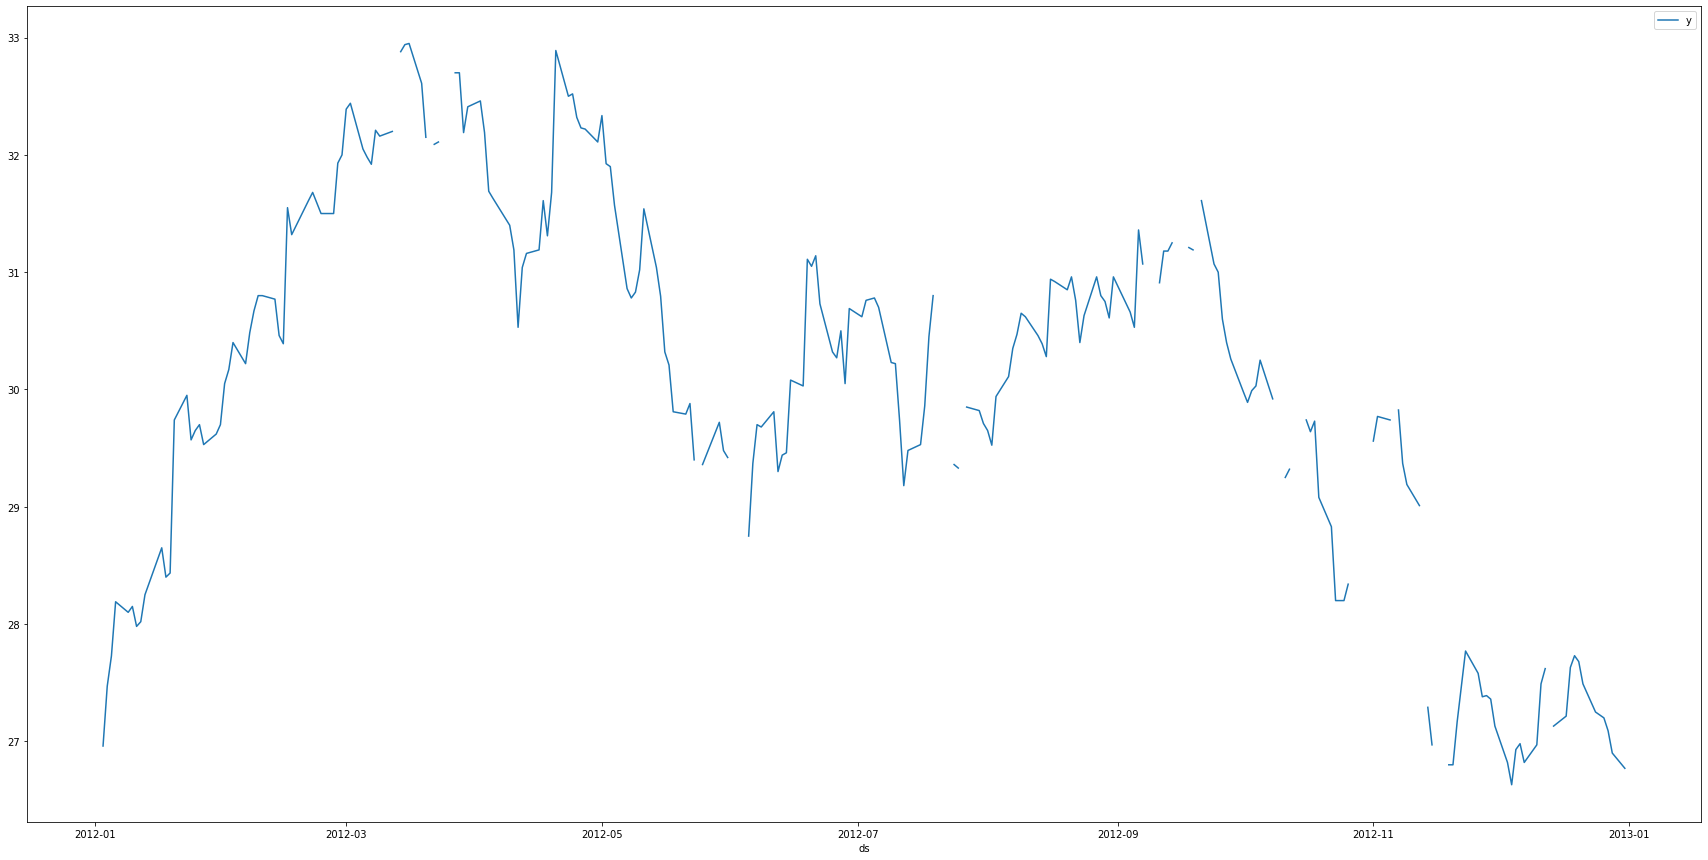

In [150]:
data.plot(x = 'ds', y = 'y', figsize = (30, 15))

In [134]:

test = data[~data.y.notnull()]
train = data[data.y.notnull()]

train_train = train.sample(frac = .8)
train_test = data.drop(train_train.index)
train_test.shape


(66, 3)

In [135]:
data.groupby('y').count().head(40)

,ds,t
y,,
26.6300,1,1
26.7700,1,1
26.8000,2,2
26.8200,2,2
26.9000,1,1
26.9300,1,1
26.9600,1,1
26.9700,2,2
26.9800,1,1


In [136]:
train_test[train_test['ds'].isin(train_test['ds'].unique())]

,ds,y,t
3,2012-01-06,28.1900,3
7,2012-01-12,28.0200,7
9,2012-01-17,28.6500,9
12,2012-01-20,29.7400,12
15,2012-01-25,29.6500,15
...,...,...,...
223,2012-11-21,27.1666,223
227,2012-11-28,27.3900,227
233,2012-12-06,26.9800,233
238,2012-12-13,NaN,238


# Pandas interpolation

Have not tried this

# Stationary process interpolation 

In [137]:

# Trainning random forest 
rf = RandomForestRegressor()
param_grid = {
    # "criterion": ['entropy', 'log_loss'] # Advise: If you're just trying, this is not so important
    "max_depth": [10, 11, 12, 13, 14, 15]
    , "random_state": [1000]
    , "min_samples_leaf": [1,2,3,4,5,6,7,8]
}

rf = GridSearchCV(rf, param_grid, scoring = 'neg_mean_absolute_error', cv = 10, n_jobs = 6, verbose = 1) 
rf.fit(train_train[['t']], train_train.y)


Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=6,
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
                         'random_state': [1000]},
             scoring='neg_mean_absolute_error', verbose=1)

In [138]:
# Trainning kernel  

from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

kr = KernelRidge()
param_grid = {
    "kernel": ['linear', 'ExpSineSquared']
    # , "gamma": np.linspace(0, 1, num = 1000, retstep = True)
    # , "alpha": np.linspace(0, 1, num = 1000, retstep = True)
}

# kr = GridSearchCV(kr, param_grid, scoring = 'neg_mean_absolute_error', cv = 10, n_jobs = 6, verbose = 1) 
kr.fit(train_train[['t']], train_train.y)



KernelRidge()

### Performance

In [139]:

print('')
print('Tree selected paramters: ', rf.best_params_)
print('')

import numpy as np
p_rf = np.mean(abs(rf.predict(train_test[['t']]) - train_test['y'])/rf.predict(train_test[['t']]))*100
print('Loss function RF (%)', p_rf)

p_kr = np.mean(abs(kr.predict(train_test[['t']]) - train_test['y'])/kr.predict(train_test[['t']]))*100
print('Loss function Kernel Regression (%)', p_kr)



Tree selected paramters:  {'max_depth': 15, 'min_samples_leaf': 1, 'random_state': 1000}

Loss function RF (%) 0.7338968390814247
Loss function Kernel Regression (%) 349.4577706358109


# Time series methods

In [140]:

def forecast_by_Prophet(train):

    m = Prophet(daily_seasonality = True, yearly_seasonality = True) # Add seasonality 
    m.fit(train)

    # Python
    future = m.make_future_dataframe(periods=forecast_horizon)
    forecast = m.predict(future)
    forecast= forecast[['ds', 'yhat']]

    return forecast

forecast_horizon = 30


In [141]:
data.sample(5)

,ds,y,t
103,2012-05-31,29.420,103
11,2012-01-19,28.435,11
79,2012-04-26,32.230,79
183,2012-09-24,31.070,183
199,2012-10-16,29.740,199


In [142]:

forecast = forecast_by_Prophet(data)
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.date

test_dates = train_test['ds'].unique()


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2h30ng9i/rvohrbtd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2h30ng9i/uh1_7grj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93878', 'data', 'file=/tmp/tmp2h30ng9i/rvohrbtd.json', 'init=/tmp/tmp2h30ng9i/uh1_7grj.json', 'output', 'file=/tmp/tmpxtyndpjn/prophet_model-20221001215605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [143]:
train_test['yhat'] = forecast['yhat']
train_test['mae'] = abs(train_test['y'] - train_test['yhat']) / train_test['yhat']

### Performance

In [144]:
print('Loss function Prophet model (%)', train_test['mae'].mean()*100)


Loss function Prophet model (%) 0.9741886981936012


# Some dirty stuff (I want to keep for other projects)

In [91]:

def date_features(df, label = None):

    df = df.copy()
    df['ds'] = pd.to_datetime(df.ds, errors='coerce')

    # Lags 

    # Sesaonals 
    df['month'] = df['ds'].dt.strftime('%B')
    df['year'] = df['ds'].dt.strftime('%Y')
    df['dayofweek'] = df['ds'].dt.strftime('%A')
    df['quarter'] = df['ds'].dt.quarter
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

X, y = date_features(data, label='y')
df_new = pd.concat([X, y], axis=1)
df_new.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y
0,Tuesday,1,January,2012,3,3,1,26.960
1,Wednesday,1,January,2012,4,4,1,27.470
2,Thursday,1,January,2012,5,5,1,27.728
3,Friday,1,January,2012,6,6,1,28.190
4,Monday,1,January,2012,9,9,2,28.100


In [115]:
# !pip install optuna
import optuna




In [118]:
param_types = {'changepoint_prior_scale': 'float', 
               'seasonality_prior_scale': 'float',
              'seasonality_mode': 'int'}

bounds = {'changepoint_prior_scale': [0.001, 0.5],
          'seasonality_prior_scale': [0.01, 10],
          'seasonality_mode': [0, 1]}

df = data.copy(deep = True)

In [120]:

def objective(trial):
    '''Train a prophet model and return the rmse'''
    # sampling
    params = {}
    for param in ['changepoint_prior_scale', 'seasonality_prior_scale']:
        params[param] = trial.suggest_uniform(param, bounds[param][0], bounds[param][1])
        
    estacionality = ['additive', 'multiplicative']
    params['seasonality_mode'] = estacionality[trial.suggest_int('seasonality_mode', 
                                                                  bounds['seasonality_mode'][0], 
                                                                  bounds['seasonality_mode'][1])]

    # modeling
    m = Prophet(weekly_seasonality = True,
                daily_seasonality = False,
                **params)
    
    m.fit(df) 
    number_initial_days = (df.ds.max() - df.ds.min()).days - 28
    df_cv = cross_validation(m, 
                             initial = f'{number_initial_days} days', 
                             period = '7 days', 
                             horizon = '7 days',
                             parallel = "processes")
    
    df_p = performance_metrics(df_cv, rolling_window = 1)
    print(df_p['mape'].mean())
    
    return df_p['rmse'].values[0]

study = optuna.create_study()
study.optimize(objective, n_trials = 10)


[I 2022-10-01 21:18:19,226] A new study created in memory with name: no-name-1d2f0b76-cb0a-43d2-b48d-e366423daa51
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2h30ng9i/9f2_7ybi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2h30ng9i/sw2vy019.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3319', 'data', 'file=/tmp/tmp2h30ng9i/9f2_7ybi.json', 'init=/tmp/tmp2h30ng9i/sw2vy019.json', 'output', 'file=/tmp/tmpcpux_zn8/prophet_model-20221001211819.csv', 'method=optimize

NameError: ignored

In [111]:
def train_final_model(df, study):
    
    best_params = study.best_params
    params = {}
    for param in ['changepoint_prior_scale', 'seasonality_prior_scale']:
        params[param] = best_params[param]
    
    estacionality = ['additive', 'multiplicative']
    params['seasonality_mode'] = estacionality[best_params['seasonality_mode']]

    # modeling
    m = Prophet(weekly_seasonality=True,
                daily_seasonality=False,
                **params)
    
    m.fit(df)
    future = m.make_future_dataframe(periods=7)
    predictions = m.predict(future).merge(df, on='ds', how='left')
    
    return predictions

In [114]:
study.best_params

{'x': 1.987188855893766}

In [112]:
train_final_model(data, study)

KeyError: ignored